# Stream Spring (Wisteria version)
The point of this notebook is to try and do a proof of concept about streaming results out of genesis calculations. We will setup a run using the Genesis code to go in the background. Then we will create a loop which reads the trajectory file. If there's something new there, it will create new runs for BigDFT to starting calculating.

In [1]:
#!pip install remotemanager==0.11.18

In [1]:
remote_dir = "/data/scratch/jh210022a/q25020/stream"
local_dir = "stream"

In [2]:
wisteria_spec="""
    submitter: pjsub
    # this is for both odyssey and 
    template: |
        #!/bin/sh
        # #cores_per_node:default=48#  #feature of the machine
        #------ pjsub option --------#
        #PJM -L rscgrp=#queue:default=regular-a#
        #PJM -L node=#nodes:default={(mpi*omp)/cores_per_node}#
        #PJM -L gpu=#gpu#
        #PJM --mpi proc=#mpi:optional=False#
        #PJM --omp thread=#omp:optional=False#
        #PJM -L elapse=#time:format=time:optional=False#
        #PJM -g #group:default=jh210022a#
        #PJM -j

        module #module_preload#
        module load #modules#
        export PREFIX=#prefix:default=/work/jh210022a/q25020/build-odyssey/suite#
        export BIGDFT_MPIRUN="mpiexec #mpiexec_extra:default=-machinefile $PJM_O_NODEINF -n $PJM_MPI_PROC -npernode {min(cores_per_node/omp,mpi)}#"
        export FUTILE_PROFILING_DEPTH=0
        export FUTILE_DEBUG_MODE=#futile_debug:default=0#
        source $PREFIX/bin/bigdftvars.sh
        export GENESIS_ROOT=#upstream_prefixes#/bin
        export GENESIS_MPIRUN=$BIGDFT_MPIRUN
       
        #------- Program execution -------#   

    frontend_template: |
      #!/bin/bash
      module #module_preload#
      module load #modules#
      export PREFIX=#prefix:default=/work/jh210022a/q25020/build-odyssey/suite#
      export FUTILE_PROFILING_DEPTH=0
      export FUTILE_DEBUG_MODE=#futile_debug:default=0#
      source $PREFIX/bin/bigdftvars.sh
      export GENESIS_ROOT=#upstream_prefixes#/bin
      export GENESIS_MPIRUN=$BIGDFT_MPIRUN
      #command:optional=False#

    odyssey_gnu_nompi:
      fc: gfortran
      fcflags: -fPIC
      cc: gcc
      cflags: -fPIC
      cxx: g++
      modules: fj
      python_interpreter: python
      sourcedir: /home/q25020/bigdft-suite
      tarballdir:        /home/q25020/bigdft-upstream-tarballs
      checkoutroot:      /work/jh210022a/q25020/build-odyssey/checkout
      builddir:          /work/jh210022a/q25020/build-odyssey/builddir
      upstream_prefixes: /work/jh210022a/q25020/build-odyssey/upstream
      prefix:            /work/jh210022a/q25020/build-odyssey/suite

    odyssey:
      fc: mpifrtpx
      fcflags: -SSL2BLAMP -Kfast,openmp,noautoobjstack -fPIC
      cc: mpifccpx
      cflags: -g -std=gnu99 -O2 -fPIC
      cxx: mpiFCCpx
      linalg: -fjlapackex -SCALAPACK
      configure_line: F77=frtpx FFLAGS="-Kfast -fPIC" --build=x86_64-redhat-linux --host=sparc-fujitsu-linux LIBS="-SSL2BLAMP -Kfast,openmp -Nlibomp" --without-archives
      module_preload: purge
      modules: fj
      python_interpreter: python
      sourcedir: /home/q25020/bigdft-suite
      mpiexec_extra: ""
      group: jh210022o
      queue: regular-o
      cmakeargs_update: > 
          {'ntpoly': ' -DFORTRAN_ONLY=Yes -DCMAKE_Fortran_FLAGS_RELEASE="-SSL2BLAMP -Kfast,openmp" -DCMAKE_Fortran_COMPILER="mpifrtpx" -DCMAKE_C_COMPILER="mpifccpx" -DCMAKE_CXX_COMPILER="mpiFCCpx" -DCMAKE_Fortran_MODDIR_FLAG="-M"'}
      tarballdir:        /home/q25020/bigdft-upstream-tarballs
      checkoutroot:      /work/jh210022a/q25020/build-odyssey/checkout      
      builddir:          /work/jh210022a/q25020/build-odyssey/builddir
      upstream_prefixes: /work/jh210022a/q25020/build-odyssey/upstream
      prefix:            /work/jh210022a/q25020/build-odyssey/suite

    aquarius:
      fc: mpif90
      fcflags: -O2 -g -fPIC -fopenmp
      cc: mpicc
      cflags: -O2 -g -fPIC
      ompflags: -fopenmp
      cxx: mpicxx
      linalg:  -L${MKLROOT}/lib/intel64 -Wl,--no-as-needed -lmkl_gf_lp64 -lmkl_gnu_thread -lmkl_core -lgomp -lpthread -lm -ldl
      configure_line: --enable-cuda-gpu --enable-opencl "NVCC_FLAGS=--compiler-options -fPIC" --enable-single --enable-gpu --with-cuda=$CUDA_PATH LAPACK_LIBS="-L${MKLROOT}/lib/intel64 -Wl,--no-as-needed -lmkl_gf_lp64 -lmkl_gnu_thread -lmkl_core -lgomp -lpthread -lm -ldl" --enable-dynamic-libraries LIBS=-lstdc++ 
      #gpu_line: 
      build_conditions: --conditions=-vdw
      module_preload: purge
      modules: aquarius python/3.9.18 ompi mkl cuda
      python_interpreter: python
      sourcedir: /home/q25020/bigdft-suite
      tarballdir:        /home/q25020/bigdft-upstream-tarballs
      checkoutroot:      /work/jh210022a/q25020/build-aquarius/checkout
      builddir:          /work/jh210022a/q25020/build-aquarius/builddir
      upstream_prefixes: /work/jh210022a/q25020/build-aquarius/upstream
      prefix:            /work/jh210022a/q25020/build-aquarius/suite
"""

In [3]:
from yaml import load, Loader
from remotemanager import BaseComputer
wisteria_dict = load(wisteria_spec,Loader=Loader)

In [4]:
cpu = BaseComputer(host='wisteria.cc.u-tokyo.ac.jp', user='q25020', **wisteria_dict)
#cpu.test_connection()

In [5]:
gpu =  BaseComputer(host='wisteria.cc.u-tokyo.ac.jp', user='q25020', **wisteria_dict, python="python3")

We run Genesis on the GPU side.

BigDFT on the CPU side.

Extract on the front end.

In [6]:
front=BaseComputer(template=wisteria_dict['frontend_template'], submitter="bash",
                   host='wisteria.cc.u-tokyo.ac.jp', user='q25020', python="/work/opt/local/x86_64/apps/gcc/8.3.1/python/3.9.18/bin/python3")
front.command = " "

## Dataset Setups
First we need to get the Genesis calculation running in the background.

In [7]:
!rm dataset-*

rm: cannot remove 'dataset-*': No such file or directory


In [8]:
from remotemanager import Dataset
from calcs import calc_genesis
dsg = Dataset(calc_genesis, url=gpu, name="calc_genesis",
             extra_files_send=["inp", "toppar"],
             remote_dir=remote_dir, local_dir=local_dir,**wisteria_dict['aquarius'])
dsg.append_run({"geom": "1uao"},omp=1,mpi=1,time=300,cores_per_node=48)

appended run runner-0


This will feed into a BigDFT run.

In [9]:
from calcs import calc_bigdft
dsb = Dataset(calc_bigdft, url=cpu, name="linear",
              remote_dir=remote_dir, local_dir=local_dir,**wisteria_dict['odyssey'])

The geometry processor will work as a SanzuFunction.

In [10]:
#front.modules='aquarius python/3.9.18 ompi mkl cuda'

In [11]:
from remotemanager import SanzuFunction
from calcs import extract
extract = SanzuFunction(url=front, name="extract", verbose=False,
                        extra_files_recv="snapshots",
                        remote_dir=remote_dir, local_dir=local_dir, **wisteria_dict['aquarius'])(extract)

## Run Loop
Now we can setup the loop.

In [12]:
dsg.run()
while True: # this loop structure ensures we always generate runs after finished
    finished = all(dsg.is_finished)
    nsnaps = extract("1uao")
    extract.dataset.wipe_runs()
    for i in range(nsnaps):
        dsb.append_run({"geom": f"1uao-{i}", "charge": -2},omp=8,mpi=36,time=1800,cores_per_node=48)
    dsb.run()
    if finished:
        break

Running Dataset
assessing run for runner calc_genesis-203479f6-runner-0... running
Transferring 6 Files in 2 Transfers... Done
Running Dataset
appended run runner-0
appended run runner-1
appended run runner-2
appended run runner-3
appended run runner-4
Running Dataset
assessing run for runner linear-c1b3db02-runner-0... running
assessing run for runner linear-c1b3db02-runner-1... running
assessing run for runner linear-c1b3db02-runner-2... running
assessing run for runner linear-c1b3db02-runner-3... running
assessing run for runner linear-c1b3db02-runner-4... running
Transferring 12 Files... Done
runner runner-0 already exists
runner runner-1 already exists
runner runner-2 already exists
runner runner-3 already exists
runner runner-4 already exists
appended run runner-5
appended run runner-6
appended run runner-7
appended run runner-8
appended run runner-9
Running Dataset
assessing run for runner linear-c1b3db02-runner-0... skipping already submitted run
assessing run for runner linear

In [13]:
dsb.wait() ; dsb.fetch_results()
dsg.fetch_results()

Fetching results
Transferring 10 Files... Done
Fetching results
Transferring 2 Files... Done


## Data Analysis
Here is when we'd do our complexity analysis scheme, but for this notebook purpose let's just compare the total energies.

Warning! Found 1 error(s), also check the `errors` property!


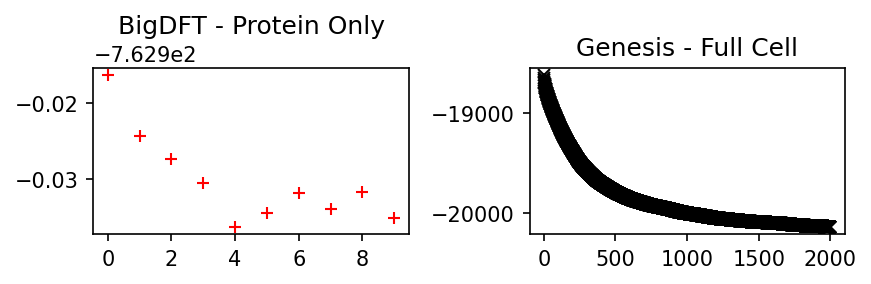

In [14]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=150)
axs[0].plot(dsb.results, 'r+')
axs[0].set_title("BigDFT - Protein Only")
axs[1].plot(dsg.results[0], 'kx')
axs[1].set_title("Genesis - Full Cell")
fig.tight_layout()

We see an initial stage of the protein being internally optimized, followed by what are likely optimizations of the water network. We might take a look at this processes with the fragment bond order.

In [15]:
def reduction(geom):
    from BigDFT.PostProcessing import BigDFTool
    from BigDFT.Logfiles import Logfile
    from BigDFT.IO import read_pdb
    from os.path import join

    tool = BigDFTool()
    # Read in the system
    with open(join("snapshots", f"{geom}.pdb")) as ifile:
        sys = read_pdb(ifile)

    # Log info
    log = Logfile(join("scr", f"log-{geom}.yaml"))
    sys.set_logfile_info(log)

    # Bond Orders
    fbo = tool.fragment_bond_order(sys, list(sys), list(sys), log)

    return fbo

In [19]:
front.python='python3'

In [22]:
dsf = Dataset(reduction, url=front, name="reduction", asynchronous=False,
              remote_dir=remote_dir, local_dir=local_dir)
for i in range(nsnaps):
    dsf.append_run({"geom": f"1uao-{i}"})
dsf.run() ; dsf. wait() ; dsf.fetch_results()

appended run runner-0
appended run runner-1
appended run runner-2
appended run runner-3
appended run runner-4
appended run runner-5
appended run runner-6
appended run runner-7
appended run runner-8
appended run runner-9
Running Dataset
assessing run for runner reduction2-2c3bfee1-runner-0... running
assessing run for runner reduction2-2c3bfee1-runner-1... running
assessing run for runner reduction2-2c3bfee1-runner-2... running
assessing run for runner reduction2-2c3bfee1-runner-3... running
assessing run for runner reduction2-2c3bfee1-runner-4... running
assessing run for runner reduction2-2c3bfee1-runner-5... running
assessing run for runner reduction2-2c3bfee1-runner-6... running
assessing run for runner reduction2-2c3bfee1-runner-7... running
assessing run for runner reduction2-2c3bfee1-runner-8... running
assessing run for runner reduction2-2c3bfee1-runner-9... running
Transferring 22 Files... Done
Fetching results
Transferring 10 Files... Done


Let's figure out which bond orders between non-consecutive amino acids are most relevant.

In [23]:
sign = []
for res in dsf.results:
    for k1 in res:
        fid1 = int(k1.split(":")[1])
        for k2, v in res[k1].items():
            fid2 = int(k2.split(":")[1])
            if fid1 <= fid2:  # only go one directions
                continue
            if fid1 == fid2 + 1:  # no consecutive amino acids
                continue
            if v > 0.01:
                sign.append((k1, k2))
sign = set(sign)

And plot them across snapshots.

In [25]:
from collections import defaultdict
vals = defaultdict(list)
for res in dsf.results:
    for k1, k2 in sign:
        vals[(k1, k2)].append(res[k1][k2] + res[k2][k1])

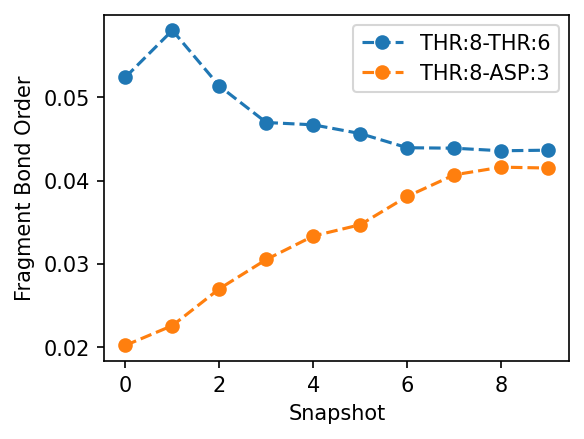

In [26]:
fig, axs = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
for k, v in vals.items():
    axs.plot(v, 'o--', label="-".join(k))
axs.set_ylabel("Fragment Bond Order")
axs.set_xlabel("Snapshot")
_ = axs.legend()

This reveals how the internal energy was stablized by strengthening of the chemical bond between Asp3 and Thr8.

## NTChem
We can also use this workflow with NTChem instead of BigDFT.

In [ ]:
from BigDFT.Interop.NTChem.BasisSets import BasisSet, get_symlookup
from BigDFT.IO import read_pdb
with open(f"stream/snapshots/1uao-0.pdb") as ifile:
    sys = read_pdb(ifile)
basis = BasisSet("6-31G*", atoms=get_symlookup(sys))

In [ ]:
from calcs import calc_ntchem
from remotemanager.serialisation import serialjsonpickle
dsn = Dataset(calc_ntchem, url=cpu, name="ntchem", serialiser=serialjsonpickle(),
              remote_dir=remote_dir, local_dir=local_dir)

In [ ]:
for i in range(nsnaps):
    dsn.append_run({"geom": f"1uao-{i}", "basis": basis, "charge": -2})

In [ ]:
dsn.run()

In [ ]:
dsn.wait() ; dsn.fetch_results()
dsn.fetch_results()

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=150)
axs[0].plot(dsn.results, 'r+')
axs[0].set_title("NTChem (HF/6-31G*) - Protein Only")
axs[1].plot(dsg.results[0], 'kx')
axs[1].set_title("Genesis - Full Cell")
fig.tight_layout()